## Задание 7, задача 4

Пусть $(X_1, ..., X_n)$ и $(Y_1, ..., Y_n)$ — связные выборки, причем разности $\varepsilon_i = Y_i-X_i$ образуют выборку с симметричным распределением. Какой из критериев
предпочтительнее использовать для проверки гипотезы об отсутствии сдвига — критерий знаков или критерий ранговых сумм Уилкоксона? Исследуйте случаи, когда $\varepsilon_i$
имеют распределения нормальное, Лапласса, Коши.


*Подсказка.* Исследуйте мощности критериев.

**Теория**

С лекции известно следующее: 

"Чем легче хвосты, тем предпочтительнее W по сравнению с $\widehat{\mu}$", где
 * W - оценка параметра сдвига в критерии ранговых сумм Уилкоксона
 * $\widehat{\mu}$ - оценка параметра сдвига в критерии знаков


Значит, лучше всего критерий ранговых сумм Уилкоксона будет работать если разности из нормального распределения, хуже всего - для Коши.

Противоположный результат должен наблюдаться для критерия знаков.

Перейдем к **практике**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from tqdm.notebook import tqdm
import sys

import scipy.stats as sps
from scipy.stats import wilcoxon
from scipy.stats import binom_test

import warnings
warnings.simplefilter("ignore")

sns.set()
%matplotlib inline
thismodule = sys.modules[__name__]

Самостоятельно реализуем Критерий знаков

In [2]:
SignedTestResult = namedtuple('SignedTestResult', ('statistic', 'pvalue'))

In [3]:
def _signedtest_n_greater_15(s, n, alternative):
    """Внутренняя функция, считает критерий знаков для случая n > 15"""
    
    assert n > 15
    
    statistics = (s - n / 2 - 1 / 2) / np.sqrt(n / 4)
    
    if alternative == 'two-sided':
        pvalue = 2 * min(sps.norm.sf(statistics), sps.norm.cdf(statistics))
    elif alternative == 'less':
        pvalue = sps.norm.cdf(statistics)
    else:
        pvalue = sps.norm.sf(statistics)

    return SignedTestResult(statistics, min(pvalue, 1))

In [4]:
def _signedtest_n_small_sizes(s, n, alternative):
    """Внутренняя функция, считает критерий знаков для случая n <= 15"""
    
    assert n <= 15
    
    statistics = s
    left_part = sps.binom.cdf(statistics, n, 1/2)
    right_part = sps.binom.sf(statistics, n, 1/2)

    if alternative == 'two-sided':
        pvalue = 2 * min(left_part, right_part)
    elif alternative == 'less':
        pvalue = left_part
    else:
        pvalue = right_part
        
    return SignedTestResult(statistics, min(pvalue, 1))

In [5]:
def signedtest(differences, alternative='two-sided'):
    """
    Критерий знаков
    Параметры
    ----------
    differences : array_like
        Массив разностей между двумя связными выборками
    alternative : {'two-sided', 'less', 'greater'}, optional
        Определение альтернативной гипотезы. 
        'two-sided' - альтернативная гипотеза: медиана ошибок не равна 0
        'less' - альтернативная гипотеза: медиана ошибок меньше 0
        'greater' - альтернативная гипотеза: медиана ошибок больше 0
    Возвращает
    -------
    statistic : float
    pvalue : float
    """
    
    assert alternative in ['two-sided', 'less', 'greater']
    
    z = differences
    z = np.unique(np.array(z))  # выкидываем совпадения
    s = np.sum(z > 0)
    n = z.shape[0]
    
    if n > 15:
        return _signedtest_n_greater_15(s, n, alternative)
    return _signedtest_n_small_sizes(s, n, alternative)



Проверим работу критериев на простых примерах


In [6]:
samples = sps.norm(2, 1).rvs(100)
print(signedtest(samples, alternative='greater'))
print(wilcoxon(samples, alternative='greater'))

SignedTestResult(statistic=9.7, pvalue=1.5074931688102024e-22)
WilcoxonResult(statistic=5044.0, pvalue=2.335341653948903e-18)


Так же в `scipy.stats` есть `binom_test`, проверяющий, правда ли выборка из бернуллевского распределения с параметром `p`. Можно было бы использовать его вместо `signedtest`, реализованного ранее.

Пример использования:

In [7]:
binom_test(np.sum(samples > 0), n=100, p=0.5)

1.5934990285464443e-28

Какие вопросы нас могут интересовать?

* Пусть минимальный интересующий нас эффект равен $\theta$. Начиная с какого размера выборки критерий будет отвеграть гипотезу об отсутствии эффекта если этот эффект присутсвует, имея при этом мощность хотя бы $\beta$. Чем меньше размер выборки - тем лучше.

* При данном фиксированном размере выборки какой минимальный эффект мы можем засечь? Чем он меньше, тем лучше.


Также не стоит забывать, что мощность мы ищем через семплирование, а значит также надо помнить про доверительный интервал вокруг полученного значения.

In [8]:
def compute_power(error_distribution,
                  one_sample_size, sample_numbers_size):
    """
    Считает реальную мощность для критерия знаков и критерия ранговых
    сумм Уилкоксона.
    Параметры
    ----------
    error_distribution : распределение ошибок, должен иметь метод rvs
    one_sample_size : int
        Размер одной выборки
    sample_numbers_size : int
        Количество генерируемых выборок
    Возвращает
    -------
    Реальную мощность критерия знаков, Реальную мощность критерия ранговых
    сумм Уилкоксона
    """
    all_errors = error_distribution.rvs(size=
                                        sample_numbers_size * one_sample_size)\
    .reshape(sample_numbers_size, one_sample_size)

    rejected_signedtest = 0
    rejected_wilcoxon = 0

    for i in range(sample_numbers_size):
        errors = all_errors[i]
        rejected_signedtest += int(signedtest(errors,
                                   alternative='greater').pvalue < 0.05)
        rejected_wilcoxon += int(wilcoxon(errors, 
                                 alternative='greater').pvalue < 0.05)
    return rejected_signedtest / sample_numbers_size,\
           rejected_wilcoxon / sample_numbers_size

### Минимальный размер выборки

Ответим на первый вопрос.

Пусть $\theta = 0.5$ --- интересующий нас эффект. Посмотрим зависимость мощности от размера выборки.

In [9]:
def add_in_arrays(prefix,
                  one_sample_size, sample_numbers_size):
    """
    Считает для данного типа ошибки (norm, laplace, cauchy)
    мощности. А также добавляет их в соответсвующие массивы
    (например, если prefix='norm', добавляет в массив norm_signedtest_powers 
    и norm_wilcoxon_powers соответсвующие резултаты)
    Параметры
    ----------
    prefix : str
        Префикс типа ошибки ("norm", "laplace", "cauchy")
    one_sample_size : int
        Размер одной выборки
    sample_numbers_size : int
        Количество генерируемых выборок
    """
    distrib = getattr(thismodule, prefix + "_distrib")
    signedtest_res, wilcoxon_res = compute_power(
        distrib,
        one_sample_size=one_sample_size, 
        sample_numbers_size=sample_numbers_size
    )
    getattr(thismodule, prefix + "_signedtest_powers").append(signedtest_res)
    getattr(thismodule, prefix + "_wilcoxon_powers").append(wilcoxon_res)

Теперь посчитаем мощности критериев в зависимости от типа ошибки и размера выборки.

In [10]:
# Минимальный эффект
theta = 0.5

# Распределения ошибок со сдвигом
norm_distrib = sps.norm(loc=theta)
laplace_distrib = sps.laplace(loc=theta)
cauchy_distrib = sps.cauchy(loc=theta)

# Массивы мощнностей в зависимости от распределения ошибок 
# и используемого критерия
norm_signedtest_powers = []
norm_wilcoxon_powers = []

laplace_signedtest_powers = []
laplace_wilcoxon_powers = []

cauchy_signedtest_powers = []
cauchy_wilcoxon_powers = []

# Количество генерируемых выборок
sample_numbers_size = 10000

# Перебор размера выборки
sizes = np.arange(2, 101, 1)

for one_sample_size in tqdm(sizes):
    add_in_arrays("norm", one_sample_size, sample_numbers_size)
    add_in_arrays("laplace", one_sample_size, sample_numbers_size)
    add_in_arrays("cauchy", one_sample_size, sample_numbers_size)

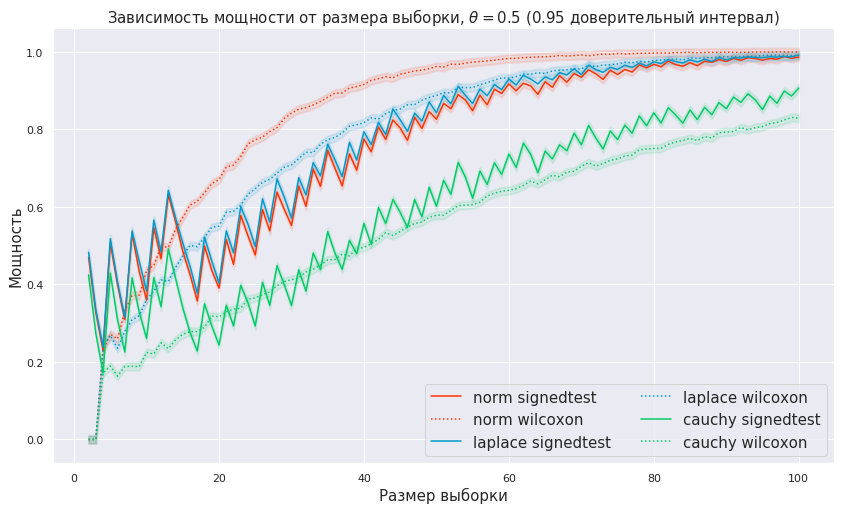

In [11]:
plt.figure(figsize=(14, 8))
plt.title(f"Зависимость мощности от размера выборки, $\\theta={theta}$"
          " (0.95 доверительный интервал)", fontsize=15)
delta = 1/np.sqrt(sample_numbers_size)
for name, color in zip(['norm', 'laplace', 'cauchy'],
                ['#FF3300', '#0099CC', '#00CC66']):
    signedtest_powers = getattr(thismodule, name + "_signedtest_powers")
    wilcoxon_powers = getattr(thismodule, name + "_wilcoxon_powers")
    plt.plot(sizes, signedtest_powers, ls="-", color = color, 
             label = name + " signedtest")
    plt.fill_between(sizes, signedtest_powers - delta, 
                     signedtest_powers + delta, alpha=0.1, 
                     lw=2, color = color)
    plt.plot(sizes, wilcoxon_powers, ls=":", 
             color = color, label = name + " wilcoxon")
    plt.fill_between(sizes, wilcoxon_powers - delta, 
                     wilcoxon_powers + delta, alpha=0.1, lw=2, color = color)
  
plt.xlabel("Размер выборки", fontsize=15)
plt.ylabel("Мощность", fontsize=15)
plt.legend(fontsize=15, ncol=2)
plt.show()

In [14]:
print("Normal: n_sign = {}, n_wilcoxon = {}".format(
      np.where(np.array(getattr(thismodule, 
                                "norm_signedtest_powers")) > 0.8)[0][0],
      np.where(np.array(getattr(thismodule, 
                                "norm_wilcoxon_powers")) > 0.8)[0][0]
))
print("Laplace: n_sign = {}, n_wilcoxon = {}".format(
      np.where(np.array(getattr(thismodule, 
                                "laplace_signedtest_powers")) > 0.8)[0][0],
      np.where(np.array(getattr(thismodule, 
                                "laplace_wilcoxon_powers")) > 0.8)[0][0]
))
      
print("Cauchy: n_sign = {}, n_wilcoxon = {}".format(
      np.where(np.array(getattr(thismodule, 
                                "cauchy_signedtest_powers")) > 0.8)[0][0],
        np.where(np.array(getattr(thismodule, 
                                "cauchy_wilcoxon_powers")) > 0.8)[0][0]
))

Normal: n_sign = 40, n_wilcoxon = 26
Laplace: n_sign = 40, n_wilcoxon = 36
Cauchy: n_sign = 69, n_wilcoxon = 90


Из графика можно сделать следующие результаты:

1) Теоретические результаты подтвердились
* Для нормального распределения лучше всего будет использовать ранговые суммы Уилкоксона
* Для Коши - наоборот, лучше использовать критерий знаков.
* У Лапласа есть в нескольких промежутках моменты, когда критерий знаков и критрерий ранговых сумм Уилкоксона дают одинаковый результат, так как есть пересечение по доверительным интервалам, но в большинстве случаев лучше показатель у ранговых суммы Уилкоксона. 
* При этом, так как хвосты у лапласа тяжелее, чем у нормального, то разница между значениями мощностей у разных критериев для лапласа меньше, чем у нормального.

2) В данном случае, если мы хотим отличать минимальный эффект хотя бы в 0.5, нужно
* Для нормального -- 26 элементов в выборке
* Для Лапласа -- 36 элементов в выборке
* Для Коши -- 69 элементов в выборке

### Мощность при фиксированном размере выборки

Теперь зафиксируем размер (в данном случае возьмем 40) и будем варьировать наименьший наблюдаемый эффект.

In [15]:
# Массивы мощнностей в зависимости от распределения ошибок 
# и используемого критерия
norm_signedtest_powers = []
norm_wilcoxon_powers = []

laplace_signedtest_powers = []
laplace_wilcoxon_powers = []

cauchy_signedtest_powers = []
cauchy_wilcoxon_powers = []

# Количество генерируемых выборок
sample_numbers_size = 10000

# Размер выборки
one_sample_size = 40

# Перебор значений минимального эффекта
theta_values = np.logspace(-1, 1, 100)

for theta in tqdm(theta_values):
    norm_distrib = sps.norm(loc=theta)
    laplace_distrib = sps.laplace(loc=theta)
    cauchy_distrib = sps.cauchy(loc=theta)
    add_in_arrays("norm", one_sample_size, sample_numbers_size)
    add_in_arrays("laplace", one_sample_size, sample_numbers_size)
    add_in_arrays("cauchy", one_sample_size, sample_numbers_size)

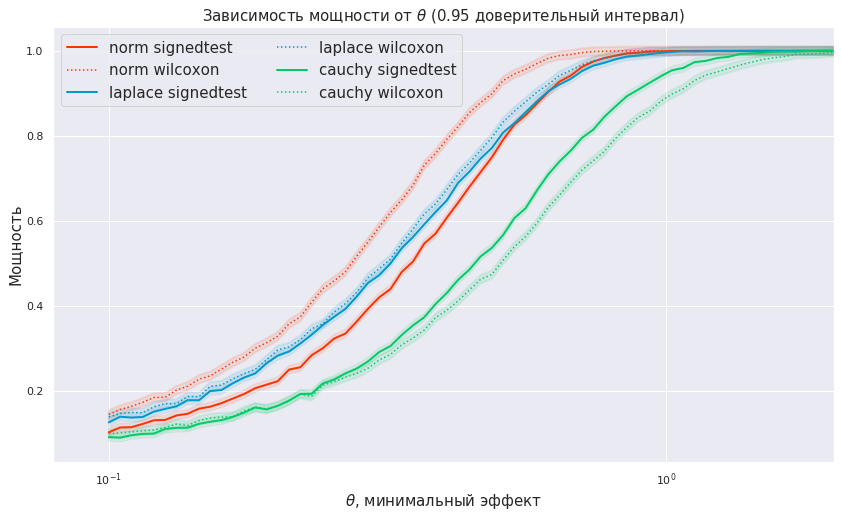

In [18]:
plt.figure(figsize=(14, 8))
plt.title(f"Зависимость мощности от $\\theta$ (0.95 доверительный интервал)", 
          fontsize=15)
delta = 1/np.sqrt(sample_numbers_size)
for name, color in zip(['norm', 'laplace', 'cauchy'],
                ['#FF3300', '#0099CC', '#00CC66']):
    signedtest_powers = getattr(thismodule, name + "_signedtest_powers")
    wilcoxon_powers = getattr(thismodule, name + "_wilcoxon_powers")
    plt.plot(theta_values, signedtest_powers, ls="-", 
             color=color, lw=2, label=name + " signedtest")
    plt.fill_between(theta_values, signedtest_powers - delta, 
                     signedtest_powers + delta, alpha=0.1, color=color)
    plt.plot(theta_values, wilcoxon_powers, ls=":", 
             color=color, label=name + " wilcoxon")
    plt.fill_between(theta_values, wilcoxon_powers - delta, 
                     wilcoxon_powers + delta, lw=2, alpha=0.1, color=color)
  
plt.xlabel("$\\theta$, минимальный эффект", fontsize=15)
plt.ylabel("Мощность", fontsize=15)
plt.xscale('log')
plt.xlim((None, 2))
plt.legend(fontsize=15, ncol=2)
plt.show()

In [21]:
print("Normal: min effect_sign = {:.3f}, min effect_wilcoxon = {:.3f}".format(
      theta_values[np.where(
          np.array(getattr(thismodule, "norm_signedtest_powers")) > 0.8
      )[0][0]],
      theta_values[np.where(
          np.array(getattr(thismodule, "norm_wilcoxon_powers")) > 0.8
      )[0][0]]
))
print("Laplace: min effect_sign = {:.3f}, min effect_wilcoxon = {:.3f}".format(
      theta_values[np.where(
          np.array(getattr(thismodule, "laplace_signedtest_powers")) > 0.8
      )[0][0]],
      theta_values[np.where(
          np.array(getattr(thismodule, "laplace_wilcoxon_powers")) > 0.8
      )[0][0]]
))
      
print("Cauchy: min effect_sign = {:.3f}, min effect_wilcoxon = {:.3f}".format(
      theta_values[np.where(
          np.array(getattr(thismodule, "cauchy_signedtest_powers")) > 0.8
      )[0][0]],
      theta_values[np.where(
          np.array(getattr(thismodule, "cauchy_wilcoxon_powers")) > 0.8
      )[0][0]]
))

Normal: min effect_sign = 0.534, min effect_wilcoxon = 0.423
Laplace: min effect_sign = 0.509, min effect_wilcoxon = 0.509
Cauchy: min effect_sign = 0.739, min effect_wilcoxon = 0.850


Как видно из графиков, теоретический результат также подтвердился. 

* В случае нормального распределения и Коши разница между мощностями критерия ранговых сумм Уилкоксона и критерия знаков отчетлива видна.

* В случае Лапласа - разницы между мощностями нет, так как доверительные интервалы пересекаются, и в данном случае неважно, какой брать критерий.

Также минимальный эффект, который будет зафиксирован с мощностью 0.8 для выборки размера 40:
 
* Для нормального -- 0.42
* Для Лапласа -- 0.51
* Для Коши -- 0.74

**Вывод:**

* Если хвосты у распределения разности между выборками тяжелые, то лучше использовать критерий знаков (например, у распределения Коши).

* В противном случае - лучше использовать критерий ранговых сумм Уилкоксона (например, если разности из нормального распределения). 

* В случае Лапласа лучше использовать все же критерий ранговых сумм Уилкоксона, но можно использовать и критерий знаков, так как разница между мощностями в обоих экспериментах выше невелика.


Итого, теоретические результаты совпали с практическими. 



